In [17]:
from astropy.table import Table, vstack
from tqdm import tqdm
from astropy.stats import bootstrap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u
import seaborn as sns
from scipy.stats import ks_2samp

In [42]:
decals_raw = Table.read('GalfitM_DECALS_183.csv', format='ascii')
decals = decals_raw[decals_raw['type_1'] != 'PSF']
d_stars = decals_raw[decals_raw['type_1'] == 'PSF']
control_sample = Table.read('GalfitM_output_control_sample_full.csv', format='ascii')
#splus = Table.read('/home/seba/Documents/CG/MorphoPLUS_SFCGs/Morphoplus_groups/Catalogos_try/GalfitM_output_final_3.csv', format='ascii')
# Definir las columnas que deseas cambiar
#columnas_a_cambiar = ['n_R', 'n_G', 'n_I', 'n_Z', 'RE_R', 'RE_G', 'RE_I', 'RE_Z', 'MAG_R', 'MAG_G', 'MAG_I', 'MAG_Z']

# Crear un diccionario para mapear los nombres antiguos a los nuevos solo para las columnas específicas
#column_mapping = {col: re.sub(r'_(G|R|I|Z)', lambda x: f'_{x.group(1).lower()}', col) for col in columnas_a_cambiar}

# Renombrar las columnas en la tabla
#for old_name, new_name in column_mapping.items():
#    if old_name in splus.colnames:
#        splus.rename_column(old_name, new_name)
        

# Convertir la tabla de astropy a un DataFrame de pandas
df = decals.to_pandas()

# Reemplazar valores infinitos por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convertir de nuevo el DataFrame a una tabla de astropy
decals = Table.from_pandas(df)
#print(decals['RE_g'])
#decals = decals[decals['mag_r_2'] < 19]
len(decals)

675

In [25]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')
    control_sample['n_' + filtro] = pd.to_numeric(control_sample['n_' + filtro], errors='coerce')
    control_sample['RE_' +filtro] = pd.to_numeric(control_sample['RE_' + filtro], errors = 'coerce')
    control_sample['e_n_' + filtro] = pd.to_numeric(control_sample['e_n_' + filtro], errors='coerce')
    control_sample['e_RE_' +filtro] = pd.to_numeric(control_sample['e_RE_' + filtro], errors = 'coerce')
    d_stars['n_' + filtro] = pd.to_numeric(d_stars['n_' + filtro], errors='coerce')
    d_stars['RE_' +filtro] = pd.to_numeric(d_stars['RE_' + filtro], errors = 'coerce')
    d_stars['e_n_' + filtro] = pd.to_numeric(d_stars['n_' + filtro], errors='coerce')
    d_stars['e_RE_' +filtro] = pd.to_numeric(d_stars['RE_' + filtro], errors = 'coerce')
    #splus['n_' + filtro] = pd.to_numeric(splus['n_' + filtro], errors='coerce')
    #splus['RE_' +filtro] = pd.to_numeric(splus['RE_' + filtro], errors = 'coerce')
    #splus['MAG_' +filtro] = pd.to_numeric(splus['MAG_' + filtro], errors = 'coerce')
    #splus['e_n_' + filtro] = pd.to_numeric(splus['n_' + filtro], errors='coerce')
    #splus['e_RE_' +filtro] = pd.to_numeric(splus['RE_' + filtro], errors = 'coerce')

In [28]:
decals_z = decals[decals['zmemb'] != 0.0]

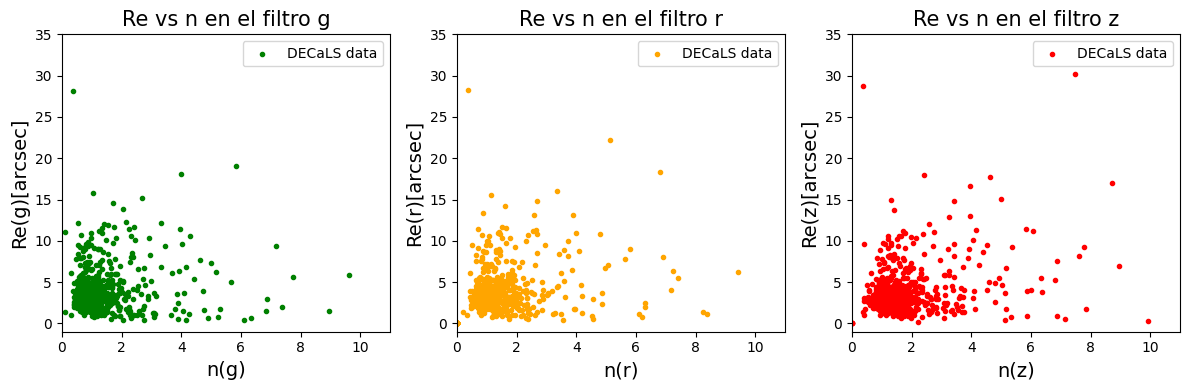

In [4]:
# Función para graficar Re vs n en grz.
def graficar_re_n(axs, archivo, color_g, color_r, color_z, label, pixel_scale):
    
    # Convertir las columnas de interés a tipos de datos numéricos
    for filtro in filtros:
        archivo['n_' + filtro] = pd.to_numeric(archivo['n_' + filtro], errors='coerce')
        archivo['RE_' +filtro] = pd.to_numeric(archivo['RE_' + filtro], errors = 'coerce')
    
    axs[0].scatter(archivo['n_g'], archivo['RE_g']*pixel_scale, label=label, color=color_g, marker='.')
    axs[0].set_xlabel('n(g)', fontsize = 14)
    axs[0].set_ylabel('Re(g)[arcsec]', fontsize=14)
    axs[0].set_title(f'Re vs n en el filtro g', fontsize=15)
    axs[0].set_xlim(0, 11)
    axs[0].set_ylim(-1, 35)

    axs[1].scatter(archivo['n_r'], archivo['RE_r']*pixel_scale, label=label, color=color_r, marker='.')
    axs[1].set_xlabel('n(r)', fontsize = 14)
    axs[1].set_ylabel('Re(r)[arcsec]', fontsize=14)
    axs[1].set_title(f'Re vs n en el filtro r', fontsize=15)
    axs[1].set_xlim(0, 11)
    axs[1].set_ylim(-1, 35)

    axs[2].scatter(archivo['n_z'], archivo['RE_z']*pixel_scale, label=label, color=color_z, marker='.')
    axs[2].set_xlabel('n(z)', fontsize = 14)
    axs[2].set_ylabel('Re(z)[arcsec]', fontsize=14)
    axs[2].set_title(f'Re vs n en el filtro z', fontsize=15)
    axs[2].set_xlim(0, 11)
    axs[2].set_ylim(-1, 35)
    
    # Añadir leyenda en cada sub-gráfico
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Graficar
graficar_re_n(axs[:], decals[decals['n_i']!=0.0], 'green', 'orange', 'red', 'DECaLS data', 0.262)
#graficar_re_n(axs[:], splus, 'cyan', 'darkorchid', 'pink', 'SPLUS data', 0.55)
#graficar_re_n(axs[:], d_stars[d_stars['n_i'] !=0.0], 'blue', 'black', 'lightgreen', 'Stars', 0.262)
# Ajustar diseño y mostrar gráficos
plt.legend()
plt.tight_layout()
plt.show()
#print(len(decals[decals['n_i']!=0.0]), len(splus))


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


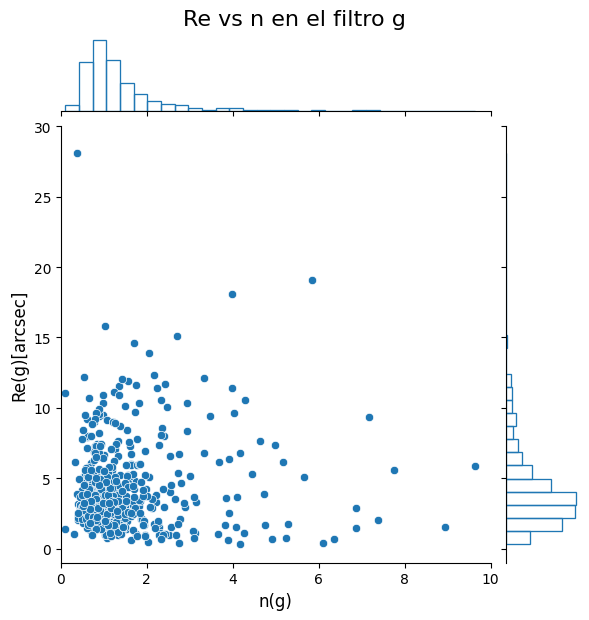

In [5]:
# Crear un gráfico conjunto con seaborn
x = decals[(decals['n_i']!=0.0) & (decals['RE_g'] != 0.0)]['n_g']
y = decals[(decals['n_i']!=0.0) & (decals['RE_g'] != 0.0)]['RE_g']*0.262

# Eliminar cualquier valor NaN o infinito en los datos filtrados
valid_indices = np.isfinite(x) & np.isfinite(y)
x = x[valid_indices]
y = y[valid_indices]

g = sns.jointplot(x=x, y=y, kind="scatter", marginal_kws=dict(bins=30, fill=False))

# Personalizar el gráfico si es necesario
g.set_axis_labels('n(g)', 'Re(g)[arcsec]', fontsize=12)
plt.suptitle('Re vs n en el filtro g', y=1.02, fontsize=16)
g.ax_joint.set_xlim(0, 10)
g.ax_joint.set_ylim(-1, 30)

# Mostrar el gráfico
plt.show()

In [22]:
bootresult_g = bootstrap(np.array([decals['n_g']][0]), bootnum=1000, bootfunc=np.nanmedian)
bootresult_r = bootstrap(np.array([decals['n_r']][0]), bootnum=1000, bootfunc=np.nanmedian)
bootresult_i = bootstrap(np.array([decals['n_i']][0]), bootnum=1000, bootfunc=np.nanmedian)
bootresult_z = bootstrap(np.array([decals['n_z']][0]), bootnum=1000, bootfunc=np.nanmedian)

# Calcular el error estándar (desviación estándar de los valores bootstrapped)
error_std_g = np.nanstd(bootresult_g)
error_std_r = np.nanstd(bootresult_r)
error_std_i = np.nanstd(bootresult_i)
error_std_z = np.nanstd(bootresult_z)

print(f"Error estándar: {error_std_g}")
print(f"Error estándar: {error_std_r}")
print(f"Error estándar: {error_std_i}")
print(f"Error estándar: {error_std_z}")


# Calcular el intervalo de confianza al 95% (percentiles 2.5% y 97.5%)
#intervalo_confianza = np.nanpercentile(bootresult, [2.5, 97.5])
#print(f"Intervalo de confianza al 95%: {intervalo_confianza}")

Error estándar: 0.027533443744608133
Error estándar: 0.02985139578608512
Error estándar: 0.032494417375566215
Error estándar: 0.04133404135515907


In [4]:
valores_sersic = np.array([decals['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus['n_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_sersic = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_sersic_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(medianas_valores_sersic)

print("\nMedianas para valores_sersic_splus:")
print(medianas_valores_sersic_splus)

NameError: name 'splus' is not defined

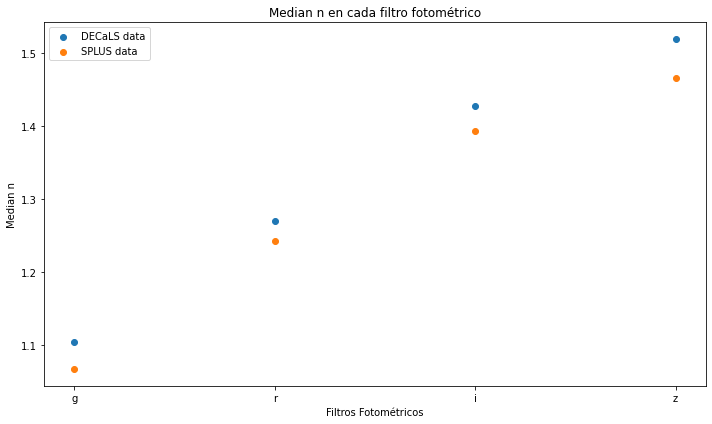

In [55]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_sersic, label='DECaLS data')
plt.scatter(filtros, medianas_valores_sersic_splus, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median n')
plt.title('Median n en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [56]:
valores_re = np.array([decals['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus['RE_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_re = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re[i]) for i in range(len(filtros))])*0.262

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re_splus[i]) for i in range(len(filtros))])*0.55

# Imprimir resultados
print("Medianas para valores_re:")
print(medianas_valores_re)

print("\nMedianas para valores_re_splus:")
print(medianas_valores_re_splus)

Medianas para valores_re:
[3.4290691 3.388577  3.329103  3.3225268]

Medianas para valores_re_splus:
[3.085445  2.782505  2.6526775 2.56795  ]


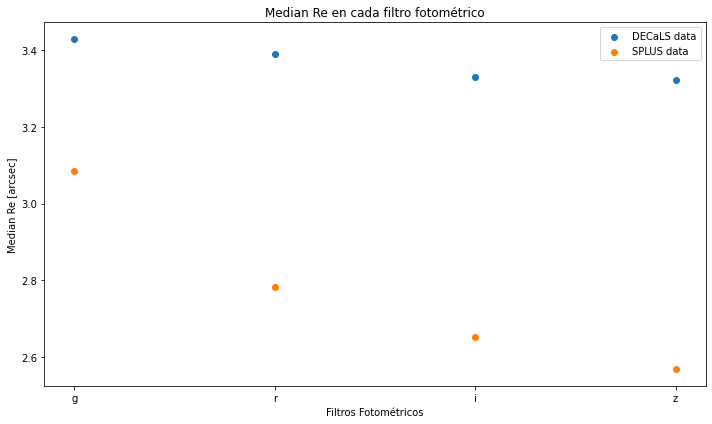

In [57]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_re, label='DECaLS data')
plt.scatter(filtros, medianas_valores_re_splus, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median Re [arcsec]')
plt.title('Median Re en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_194246/1114144826.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', shade=True, cbar=False)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


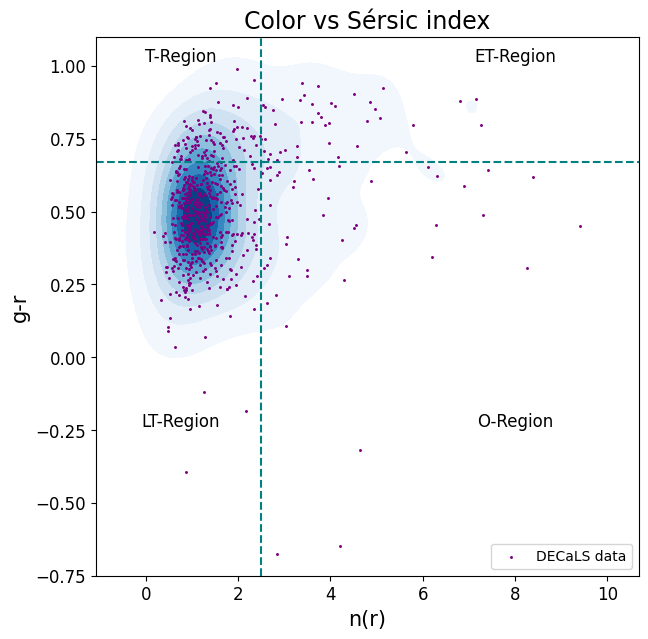

In [4]:
#u_r_o = filtered_splus['MAG_g'] - filtered_splus['MAG_r']
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['MAG_g_1'] - decals_no_zero['MAG_r_1']
n_r = decals_no_zero['n_r']
decals_no_zero_stars = d_stars[d_stars['n_r']!=0.0]
g_r_decals_stars = decals_no_zero_stars['MAG_g_1'] - decals_no_zero_stars['MAG_r_1']
plt.figure(figsize=(7, 7))

sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', shade=True, cbar=False)
plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data', s=5, color='purple')

#plt.scatter(decals_no_zero_stars['n_r'], g_r_decals_stars, marker='.', label='Stars')

plt.ylim(-0.75, 1.1)
#plt.xlim(0, )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Color vs Sérsic index', size=17)
plt.xlabel('n(r)', size=15)
plt.ylabel('g-r', size=15)
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='teal', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='teal', linestyle='--')

# Agregar texto en coordenadas específicas
plt.text(0.75, 1, 'T-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=12, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=12, ha='center', va='bottom', color='black')

plt.show()

In [5]:
grouped_decals = decals.group_by('Group_1')

valid_groups=[]

for group in grouped_decals.groups:
    if any (group['zmemb'] != 0):
        valid_groups.append(group['Group_1'][0])

filtered_table = decals[np.isin(decals['Group_1'], valid_groups)]

# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb'][group['zmemb'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group_1').groups:
    result_groups.append(replace_zeros(group))

table_redshift = vstack(result_groups)

final_table = table_redshift[(table_redshift['n_i']!=0.0) & (table_redshift['flux_i'] != 0.0)]
final_table_z = table_redshift[(table_redshift['n_z'] != 0.0) & (table_redshift['flux_z'] != 0.0)]


print(len(final_table_z))

445


### Calculamos la masa estelar de las galaxias (Taylor et al. 2011)

##### $log(M_{*}/M_{\odot}) = 1.15 + 0.7 \times (g-i)_{0} - 0.4 \times M_{i}$

### La magnitud absoluta utilizando el módulo de distancia 

#### $m - M = 5log(\frac{D}{1pc}) - 5 $

### La distancia utilizando Ley de Hubble-Lemaitre

#### $D = \frac{cz}{H_{0}}$

Con c = 300000 km/s y $H_0$ = 67.4 km/s/Mpc

In [6]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table['Distance (Mpc)'] = (final_table['zmemb']*c)/H_0

final_table['M_FUV'] = final_table['FUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_NUV'] = final_table['NUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_i'] = final_table['mag_i_2'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_z'] = final_table['mag_z_2'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5

final_table['log(M_*)'] = (1.15 + 0.7*(final_table['mag_g_2'] - final_table['mag_i_2']) - 0.4*final_table['M_i'])*u.M_sun
final_table['log(M_*)_z'] = (1.15 + 0.7*(final_table['mag_g_2'] - final_table['mag_z_2']) - 0.4*final_table['M_z'])*u.M_sun

In [7]:
final_table_z['Distance (Mpc)'] = (final_table_z['zmemb']*c)/H_0

final_table_z['M_z'] = final_table_z['mag_z_2'] - 5*np.log10(final_table_z['Distance (Mpc)']*1000000) + 5
final_table_z['log(M_*)'] = (1.15 + 0.7*(final_table_z['mag_g_2'] - final_table_z['mag_z_2']) - 0.4*final_table_z['M_z'])*u.M_sun

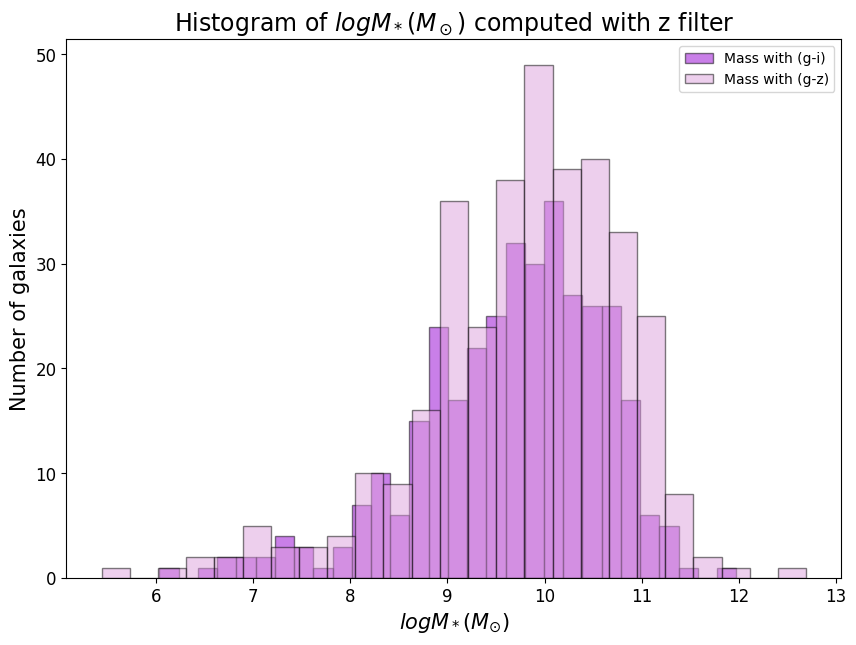

In [8]:
plt.figure(figsize=(10, 7))
# Suponiendo que 'final_table' y 'final_table_z' son tus tablas
data1 = final_table['log(M_*)']
data2 = final_table['log(M_*)_z']

# Crear el histograma con transparencia
plt.hist(data1, bins=30, alpha=0.5, label='Mass with (g-i)', color='darkviolet', edgecolor='black')
plt.hist(data2, bins=25, alpha=0.5,label='Mass with (g-z)', color='plum', edgecolor='black')

# Agregar etiquetas y título
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('$log M_* (M_{\odot})$', size=15)
plt.ylabel('Number of galaxies', size=15)
plt.title('Histogram of $log M_*(M_\odot)$ computed with z filter', size=17)

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Coeficiente de correlación: 0.9920777646350132


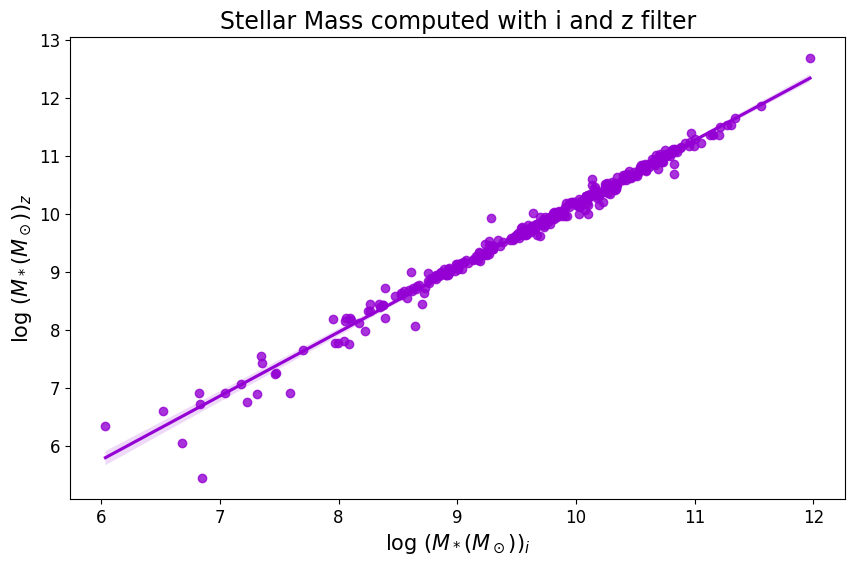

In [9]:
# Verificar y limpiar los datos
valid_indices = np.isfinite(data1) & np.isfinite(data2)
data1_clean = data1[valid_indices]
data2_clean = data2[valid_indices]

# Calcular el coeficiente de correlación solo si hay datos válidos
if len(data1_clean) > 0 and len(data2_clean) > 0:
    correlation_coefficient = np.corrcoef(data1_clean, data2_clean)[0, 1]
    print("Coeficiente de correlación:", correlation_coefficient)
else:
    print("No hay suficientes datos válidos para calcular el coeficiente de correlación.")

# Configurar la figura y el tamaño
plt.figure(figsize=(10, 6))

# Graficar la regresión lineal
sns.regplot(x=data1_clean, y=data2_clean, color='darkviolet')

# Configurar etiquetas de los ejes
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('log ($M_*(M_\odot))_i$', size=15)
plt.ylabel('log ($M_*(M_\odot))_z$', size=15)
plt.title('Stellar Mass computed with i and z filter', size=17)

# Mostrar el gráfico
plt.show()

In [48]:
# Leer la tabla desde el archivo CSV
gwsl = Table.read('xmatch_gswl.csv', format='ascii')

# Nuevos nombres para las columnas que comienzan con 'col'
new_column_names = ['ObjID', 'GLXID', 'plate', 'MJD', 'fiber_ID', 'RA', 'Decl', 'z', 'chi²', 'log_M_stellar', 
                    'err_log_M_stellar', 'log_SFR_SED', 'err_log_SFR_SED', 'A_FUV', 'err_A_FUV', 'A_B', 
                    'err_A_B', 'A_V', 'err_A_V', 'flag_sed', 'UV_survey', 'flag_uv', 'flag_midir', 'flag_mgs']

# Contador para los nuevos nombres
new_name_index = 0

# Renombrar las columnas que comienzan con 'col'
for old_name in gwsl.colnames:
    if old_name.startswith('col'):
        gwsl.rename_column(old_name, new_column_names[new_name_index])
        new_name_index += 1
gwsl

ObjID,GLXID,plate,MJD,fiber_ID,RA,Decl,z,chi²,log_M_stellar,err_log_M_stellar,log_SFR_SED,err_log_SFR_SED,A_FUV,err_A_FUV,A_B,err_A_B,A_V,err_A_V,flag_sed,UV_survey,flag_uv,flag_midir,flag_mgs,_RAJ2000_1,_DEJ2000_1,Group,Gal,RAJ2000_1,DEJ2000_1,zmemb_1,gmemb_1,FUV_1,NUV_1,Simbad_1,Separation_1,Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000_2,_DEJ2000_2,Group_2,Gal_2,RAJ2000_2,DEJ2000_2,zmemb_2,gmemb_2,FUV_2,NUV_2,Simbad_2,Separation_2,Separation_2a,Separation
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64
1237648720151511345,6381963739594231963,278,51900,87,167.51669,-1.004932,0.1098,1.05,10.126,0.078,0.669,0.035,1.305,0.146,0.171,0.042,0.102,0.03,0,1,3,2,1,167.5169583,-1.00475,97,2,11 10 04.07,-01 00 17.1,0.109852,--,20.0003,19.0302,Simbad,1.1670151244919116,97,2,391,167.5168502117463,-1.004677110111772,EXP,0.574185303565978,784.4078,0.0028,774.8491,0.0019,4.9786,0.0106,17.975,0.0018,1.4321,0.008,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.8736,0.0071,17.6582,0.0012,1.4060,0.0049,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.7734,0.0079,17.3338,0.0014,1.381,0.005,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.665,0.0125,17.3093,0.0022,1.3540,0.0085,0.5077,0.0008,55.4309,0.0789,325278,1676m010,391,EXP,167.5168502117463,-1.004677110111772,0.037206035,4.384323,5.5599747,5.2908816,4.533846,1.1402005,1.31659,1.0861177,1.1228145,1.0,0.0,3.681527,280.40057,-0.47609255,5756.203,0.4195744,6383.8433,20.895243,20.637318,20.69118,20.858833,21.112875,--,16.409658,12.971799,0.25792503,-0.053861618,-0.22151566,-0.16765404,167.5169583,-1.00475,97,2,11 10 04.07,-01 00 17.1,0.109852,--,20.0003,19.0302,Simbad,0.4692778376917035,0.0,0.0
1237648720152035469,6381963749257908697,279,51984,201,168.64726,-0.867553,0.0692,0.56,9.833,0.075,0.408,0.06,1.432,0.195,0.322,0.089,0.218,0.069,0,1,3,2,1,168.6475417,-0.8678056,273,5,11 14 35.41,-00 52 04.1,0.069293,--,19.6415,18.8591,Simbad,1.3620349273567411,273,5,3416,168.6477687319171,-0.8678292086364374,SER,0.799594529715566,502.4512,0.0051,477.8328,0.0033,10.188,0.0198,17.4823,0.0016,1.3054,0.0043,0.5525,0.0006,73.5156,0.0745,502.4512,0.0051,477.8328,0.0033,10.0116,0.0134,17.0709,0.0012,1.4697,0.0029,0.5525,0.0006,73.5156,0.0745,502.4512,0.0051,477.8328,0.0033,9.8433,0.0201,16.918,0.0018,1.6264,0.0044,0.5525,0.0006,73.5156,0.07

In [50]:
grouped_gwsl = gwsl.group_by('Group_1')

valid_groups=[]

for group in grouped_gwsl.groups:
    if any (group['zmemb_1'] != 0):
        valid_groups.append(group['Group_1'][0])

filtered_table = gwsl[np.isin(gwsl['Group_1'], valid_groups)]

# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb_1'][group['zmemb_1'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb_1'] = np.where(group['zmemb_1'] == 0, replacement_value, group['zmemb_1'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group_1').groups:
    result_groups.append(replace_zeros(group))

table_redshift = vstack(result_groups)

final_table_gwsl = table_redshift[(table_redshift['n_z']!=0.0) & (table_redshift['flux_z'] != 0.0)]
len(final_table_gwsl)

147

In [51]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table_gwsl['Distance (Mpc)'] = (final_table_gwsl['zmemb_1']*c)/H_0

final_table_gwsl['M_z'] = final_table_gwsl['mag_z_2'] - 5*np.log10(final_table_gwsl['Distance (Mpc)']*1000000) + 5
#final_table_gwsl['M_i'] = final_table_gwsl['mag_i_2'] - 5*np.log10(final_table_gwsl['Distance (Mpc)']*1000000) + 5
#final_table_gwsl['log(M_*)_i'] = (1.15 + 0.7*(final_table_gwsl['mag_g_2'] - final_table_gwsl['mag_i_2']) - 0.4*final_table_gwsl['M_i'])*u.M_sun
final_table_gwsl['log(M_*)_z'] = (1.15 + 0.7*(final_table_gwsl['mag_g_2'] - final_table_gwsl['mag_z_2']) - 0.4*final_table_gwsl['M_z'])*u.M_sun

Coeficiente de correlación: 0.6639378919675352


Text(0.5, 1.0, 'Stellar Mass computed with color and SED')

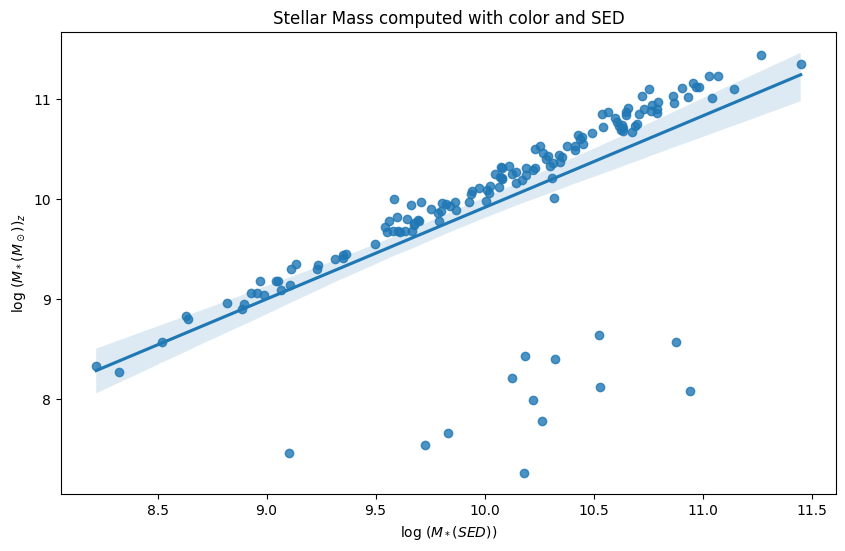

In [52]:
mass_sed = final_table_gwsl['log_M_stellar'][(final_table_gwsl['log_M_stellar'] > 0)]
mass_phot = final_table_gwsl['log(M_*)_z'][(final_table_gwsl['log_M_stellar'] > 0)]
# Verificar y limpiar los datos
valid_indices = np.isfinite(mass_sed) & np.isfinite(mass_phot)
mass_sed_clean = mass_sed[valid_indices]
mass_phot_clean = mass_phot[valid_indices]

# Calcular el coeficiente de correlación solo si hay datos válidos
if len(mass_sed_clean) > 0 and len(mass_phot_clean) > 0:
    correlation_coefficient = np.corrcoef(mass_sed_clean, mass_phot_clean)[0, 1]
    print("Coeficiente de correlación:", correlation_coefficient)
else:
    print("No hay suficientes datos válidos para calcular el coeficiente de correlación.")

# Configurar la figura y el tamaño
plt.figure(figsize=(10, 6))

# Graficar los datos de dispersión
#plt.scatter(mass_sed_clean, mass_phot_clean, marker='.')

# Graficar la regresión lineal
sns.regplot(x=mass_sed_clean, y=mass_phot_clean)

# Configurar etiquetas de los ejes y límites del eje x
plt.xlabel('log ($M_*(SED$))')
plt.ylabel('log ($M_*(M_\odot$))$_z$')
plt.title('Stellar Mass computed with color and SED')
# Mostrar el gráfico
#plt.show()

## Para calcular SFR

$log SFR_{NUV} (M_{\odot}yr^{-1}) = log L_{NUV}, corr(L_{\odot}) -9.33$

$log SFR_{FUV} (M_{\odot}yr^{-1}) = log L_{FUV}, corr(L_{\odot}) -9.51$

$A_{NUV} = -0.0495x^{3} + 0.4718x^{2} + 0.8998x + 0.2269$

$A_{FUV} = -0.0333y^{3} + 0.3522y^{2} + 1.1960y + 0.4967$

### La Luminosidad la calculamos con el flujo

$m_{x} = -2.5log(F) - 48.6$

#### $F = 10^{-\frac{(m_{x} + 48.6)}{2.5}}$

$L = 4\pi D^2 F$


In [39]:
def calcular_sfr(archivo):
    H_0 = 67.4 #km/s/Mpc
    c = 300000
    L_sun = 3.83*10**33
    eta_fuv = 1.98e+15
    eta_nuv = 1.32e+15
    eta_w3 = 2.5e+13
    eta_w4 = 1.25e+13

    archivo['Distance (Mpc)'] = (archivo['zmemb']*c)/H_0
    archivo['M_FUV'] = archivo['FUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_NUV'] = archivo['NUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #Contiene transformación de sistema de referencia de Vega a AB
    #archivo['M_w3'] = archivo['mag_w3'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #archivo['M_w4'] = archivo['mag_w4'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_z'] = archivo['mag_z_2'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5

    archivo['log(M_stellar)'] = (1.15 + 0.7*(archivo['mag_g_2'] - archivo['mag_z_2']) - 0.4*archivo['M_z'])*u.M_sun
    
    archivo['F_FUV'] = 10**(-(archivo['FUV']+48.6)/2.5)*eta_fuv
    archivo['F_NUV'] = 10**(-(archivo['NUV']+48.6)/2.5)*eta_nuv
    #archivo['F_w3'] = 10**(-(archivo['mag_w3']+48.6)/2.5)*eta_w3
    #archivo['F_w4'] = 10**(-(archivo['mag_w4']+48.6)/2.5)*eta_w4
    archivo['L_FUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_FUV']
    archivo['L_NUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_NUV']
    #archivo['L_w3'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w3']
    #archivo['L_w4'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w4']

    SFR_NUV=[]
    SFR_FUV=[]
    L=[]
    #anuv=[]
    #afuv=[]
    for i in range(len(archivo)):
        #Razón entre L_IR y L_FUV, NUV para la correción por polvo
        #x_nuv = np.log10(archivo['F_w4'][i]/archivo['F_NUV'][i])
        #y_fuv = np.log10(archivo['F_w4'][i]/archivo['F_FUV'][i])
        #Calculando A_nuv y A_fuv 
        #a_nuv = -0.0495*x_nuv**3 + 0.4718*x_nuv**2 + 0.8998*x_nuv + 0.2269
        #a_fuv = -0.0333*y_fuv**3 + 0.3522*y_fuv**2 + 1.1960*y_fuv + 0.4967

        #Calculando el flujo corregido por polvo
        #F_FUV = 10**(-(archivo['FUV'][i] - a_fuv + 48.6)/2.5)*eta_fuv
        F_NUV = 10**(-(archivo['NUV'][i] - 0.78 + 48.6)/2.5)*eta_nuv
        #Calculando la Luminosidad corregida en L_sun 
        #L_FUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_FUV)/L_sun
        L_NUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_NUV)/L_sun
        #L.append(L_FUV_cor)
        #Calculando la SFR en FUV y NUV
        #sfr_FUV = np.log10(L_FUV_cor) - 9.51
        sfr_NUV = np.log10(L_NUV_cor) - 9.33

        #anuv.append(a_nuv)
        #afuv.append(a_fuv)
        SFR_NUV.append(sfr_NUV)
        #SFR_FUV.append(sfr_FUV)

    archivo['logSFR_NUV'] = SFR_NUV
    #archivo['logSFR_FUV'] = SFR_FUV
    #print(anuv)
    #print(afuv)
    #print(min(anuv), max(anuv))
    #print(min(afuv), max(afuv))
    #plt.hist(anuv, color='blue', bins=20)
    #plt.hist(afuv, color='red', bins=20)
    #plt.show()
    archivo['log_sSFR'] = archivo['logSFR_NUV'] - archivo['log(M_stellar)']

    return archivo
    
def filtrado(archivo):
    grouped = archivo.group_by('Group_1')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group_1'][0])

    filtered_table = archivo[np.isin(archivo['Group_1'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group_1').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)

    # Función para verificar si un valor es numérico
    def is_number(value):
        try:
            float(value)
            return True
        except (ValueError, TypeError):
            return False

    # Convertir los valores enmascarados a string y eliminar espacios en blanco
    #final_table['mag_w4'] = [str(x).strip() for x in final_table['mag_w4']]

    # Crear una máscara booleana para los valores numéricos
    #mask = [is_number(x) for x in final_table['mag_w4']]

    # Aplicar la máscara para filtrar la tabla
    #final_table = final_table[mask]

    # Convertir la columna a tipo flotante
    #final_table['mag_w4'] = final_table['mag_w4'].astype(float)

    # Eliminar filas con valores NaN
    #final_table = final_table[~np.isnan(final_table['mag_w4'])]

    # Eliminar filas con valores infinitos
    #final_table = final_table[np.isfinite(final_table['mag_w4'])]
    final_table = final_table[(final_table['n_z'] != 0.0) & (final_table['flux_z'] != 0.0)]

    archivo = final_table
    

    return archivo

In [40]:
sfr_decals_z = calcular_sfr(filtrado(decals_z))
sfr_decals_z

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation,Distance (Mpc),M_FUV,M_NUV,M_z,log(M_stellar),F_FUV,F_NUV,L_FUV,L_NUV,logSFR_NUV,log_sSFR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solMass,,,,,,
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,float64,float64,str8,str8,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64
2,1,910,0.3129815262621921,13.11314170389291,SER,2.13987225133761,1111.3452,0.0166,746.5955,0.0141,36.5639,0.0625,16.3771,0.0015,1.1081,0.0026,0.2528,0.0003,49.7993,0.0245,1111.3452,0.0166,746.5955,0.0141,36.266,0.0488,15.8409,0.0013,1.0998,0.0019,0.2528,0.0003,49.7993,0.0245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1111.3452,0.0166,746.5955,0.0141,35.6739,0.1028,15.4709,0.0026,1.0833,0.0042,0.2528,0.0003,49.7993,0.0245,404689,0003p130,910,SER,0.3129815262621921,13.11314170389291,0.08065711,265.1013,444.5779,0.0,644.8338,1.5809548,1.3426262,0.0,1.5098474,1.0687332,373129.8,9.556523,44885.47,-0.1056844,7462593.0,0.58465093,14950313.0,16.441471,15.880131,--,15.47638,16.136421,16.660906,15.554382,16.187887,0.56134033,--,0.40375042,--,0.3132083,13.1134167,2,1,00 01 15.17,+13 06 48.3,0.018646,--,18.5922,18.186,Simbad,1.2697445983097178,0.0,82.99406528189911,-16.00303519034584,-16.40923519034584,-19.11885519034584,9.473105776138336,2.628967336476678e-12,2.5478504404776322e-12,2.1671100883757975e+42,2.100243816886531e+42,-0.2789290591480835,-9.75203483528642
3,4,7291,2.852407391719842,-53.9310223008958,SER,1.29447802358204,601.2763,0.0035,1023.7382,0.0044,36.266,0.0217,15.404,0.0005,0.9882,0.0009,0.7673,0.0002,11.9182,0.0501,601.2763,0.0035,1023.7382,0.0044,39.4389,0.0252,14.7606,0.0005,1.5277,0.001,0.7673,0.0002,11.9182,0.0501,601.2763,0.0035,1023.7382,0.0044,42.4663,0.0458,14.4776,0.0008,2.0424,0.0017,0.7673,0.0002,11.9182,0.0501,601.2763,0.0035,1023.7382,0.0044,45.7435,0.0716,14.2780,0.0011,2.5997,0.0027,0.7673,0.0002,11.9182,0.0501,63164,0027m540,7291,SER,2.852407391719842,-53.9310223008958,0.013674323,723.31555,1240.6438,1596.1914,1837.1049,1.3978636,1.2477674,1.1959314,1.1699084,1.5316923,2717180.5,10.513629,242138.9,0.11245582,56035076.0,0.029920407,27842356.0,15.351681,14.765882,14.492288,14.339665,14.798617,15.245937,13.267138,13.086854,0.58579826,0.27359486,0.42621708,0.15262222,2.8522917,-53.9311944,3,4,00 11 24.55,-53 55 52.3,0.041719,--,17.7296,17.3873,Simbad,0.6663177943600813,0.0,185.6928783382789,-18.614376240354904,-18.956676240354906,-22.00431124

In [180]:
sfr_gwsl = calcular_sfr(filtrado(final_table_gwsl))
sfr_gwsl

ObjID,GLXID,plate,MJD,fiber_ID,RA,Decl,z,chi²,log_M_stellar,err_log_M_stellar,log_SFR_SED,err_log_SFR_SED,A_FUV,err_A_FUV,A_B,err_A_B,A_V,err_A_V,flag_sed,UV_survey,flag_uv,flag_midir,flag_mgs,_RAJ2000_1,_DEJ2000_1,Group,Gal,RAJ2000_1,DEJ2000_1,zmemb_1,gmemb_1,FUV_1,NUV_1,Simbad_1,Separation_1,Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000_2,_DEJ2000_2,Group_2,Gal_2,RAJ2000_2,DEJ2000_2,zmemb_2,gmemb_2,FUV_2,NUV_2,Simbad_2,Separation_2,Separation_2a,Separation,Distance (Mpc),M_FUV,M_NUV,M_z,log(M_stellar),F_FUV,F_NUV,L_FUV,L_NUV,logSFR_NUV,log_sSFR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solMass,,,,,,
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64
1237652901825937430,6380310082695988426,655,52162,322,9.413301,-9.046804,0.0772,1.84,10.415,0.038,0.292,0.081,0.97,0.226,0.487,0.121,0.404,0.104,0,1,3,2,1,9.4132917,-9.0465556,14,1,00 37 39.19,-09 02 47.6,0.077266,--,18.8397,18.909,Simbad,0.8948510347891258,14,1,1410,9.413276734868823,-9.046817280354563,REX,0.534268261272064,854.2617,0.0046,822.1948,0.0044,13.1023,0.0141,17.1853,0.001,0.964,0.0018,0.9456,0.0006,73.2998,0.4664,854.2617,0.0046,822.1948,0.0044,12.7876,0.0096,16.5841,0.0007,1.0310,0.0012,0.9456,0.0006,73.2998,0.4664,854.2617,0.0046,822.1948,0.0044,12.4872,0.0111,16.3156,0.001,1.0949,0.0015,0.9456,0.0006,73.2998,0.4664,854.2617,0.0046,822.1948,0.0044,12.1622,0.0176,16.1553,0.0011,1.1641,0.0024,0.9456,0.0006,73.2998,0.4664,278747,0094m090,1410,REX,9.413276734868823,-9.046817280354563,0.035117216,127.33453,225.82289,295.6194,346.85437,1.3626305,1.2939789,1.2051785,1.556511,1.0,0.0,3.139772,362204.1,0.0,0.0,0.0,0.0,17.237635,16.61558,16.323168,16.149632,16.360336,16.981625,15.316439,14.393671,0.62205505,0.2924118,0.4659481,0.1735363,9.4132917,-9.0465556,14,1,00 37 39.19,-09 02 47.6,0.077266,--,18.8397,18.909,Simbad,0.943550495260575,0.0,0.0,343.91394658753705,-18.842548939639222,-18.773248939639224,-21.532616939639222,10.52464887585569,2.09307692687762e-12,1.3091033409054691e-12,2.9626917872068705e+43,1.8529991262631118e+43,0.6666764405692689,-9.85797243528642
1237652901825937433,6380310082695988332,655,52162,371,9.432746,-9.065414,0.0764,2.56,9.709,0.04

Coeficiente de correlación: 0.8777868803852602


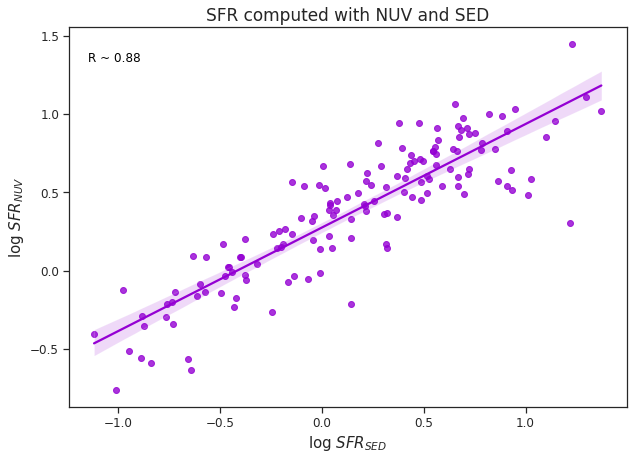

In [194]:
sfr_sed = sfr_gwsl['log_SFR_SED'][sfr_gwsl['log_SFR_SED'] > -80]
sfr_phot = sfr_gwsl['logSFR_NUV'][sfr_gwsl['log_SFR_SED'] > -80]

# Verificar y limpiar los datos
valid_indices = np.isfinite(sfr_sed) & np.isfinite(sfr_phot)
sfr_sed_clean = sfr_sed[valid_indices]
sfr_phot_clean = sfr_phot[valid_indices]

# Calcular el coeficiente de correlación solo si hay datos válidos
if len(sfr_sed_clean) > 0 and len(sfr_phot_clean) > 0:
    correlation_coefficient = np.corrcoef(sfr_sed_clean, sfr_phot_clean)[0, 1]
    print("Coeficiente de correlación:", correlation_coefficient)
else:
    print("No hay suficientes datos válidos para calcular el coeficiente de correlación.")

# Configurar la figura y el tamaño
plt.figure(figsize=(10, 7))

# Graficar los datos de dispersión
#plt.scatter(mass_sed_clean, mass_phot_clean, marker='.')

# Graficar la regresión lineal
sns.regplot(x=sfr_sed_clean, y=sfr_phot_clean, color='darkviolet')

# Configurar etiquetas de los ejes y límites del eje x
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('log $SFR_{SED}$', size=15)
plt.ylabel('log $SFR_{NUV}$', size=15)
plt.title('SFR computed with NUV and SED', size=17)
plt.text(-1.15, 1.4, 'R ~ 0.88', color='black', fontsize=12, verticalalignment='top')

# Mostrar el gráfico
plt.show()

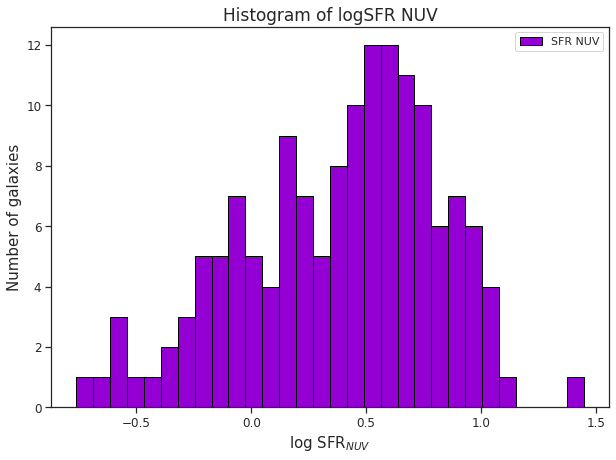

0.4706600468533697 9.946009635448716


In [187]:
# Suponiendo que 'final_table' y 'final_table_z' son tus tablas
data1 = sfr_gwsl['logSFR_NUV']
#data2 = sfr_all['logSFR_FUV']
plt.figure(figsize=(10, 7))
# Crear el histograma con transparencia
plt.hist(data1, bins=30, alpha=1, label='SFR NUV', color='darkviolet', edgecolor='black')
#plt.hist(data2, bins=30, alpha=0.5, label='SFR FUV', color='purple')

# Agregar etiquetas y título
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('log SFR$_{NUV}$', size=15)
plt.ylabel('Number of galaxies', size=15)
plt.title('Histogram of logSFR NUV', size=17)

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print(np.median(data1), np.median(data2))

In [4]:
sfr_decals.write('sfr_decals.csv', format='csv')

NameError: name 'sfr_decals' is not defined

In [6]:
sfr_decals = Table.read('sfr_decals.csv', format='ascii')
sfr_decals

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation,Distance (Mpc),M_FUV,M_NUV,M_z,log(M_stellar),F_FUV,F_NUV,L_FUV,L_NUV,logSFR_NUV,log_sSFR
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,1,910,0.3129815262621921,13.11314170389291,SER,2.13987225133761,1111.3452,0.0166,746.5955,0.0141,36.5639,0.0625,16.3771,0.0015,1.1081,0.0026,0.2528,0.0003,49.7993,0.0245,1111.3452,0.0166,746.5955,0.0141,36.266,0.0488,15.8409,0.0013,1.0998,0.0019,0.2528,0.0003,49.7993,0.0245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1111.3452,0.0166,746.5955,0.0141,35.6739,0.1028,15.4709,0.0026,1.0833,0.0042,0.2528,0.0003,49.7993,0.0245,404689,0003p130,910,SER,0.3129815262621921,13.11314170389291,0.08065711,265.1013,444.5779,0.0,644.8338,1.5809548,1.3426262,0.0,1.5098474,1.0687332,373129.8,9.556523,44885.47,-0.1056844,7462593.0,0.58465093,14950313.0,16.441471,15.880131,--,15.47638,16.136421,16.660906,15.554382,16.187887,0.56134033,--,0.40375042,--,0.3132083,13.1134167,2,1,00 01 15.17,+13 06 48.3,0.018646,--,18.5922,18.186,Simbad,1.2697445983097178,0.0,82.99406528189911,-16.00303519034584,-16.40923519034584,-19.11885519034584,9.473105776138336,2.628967336476678e-12,2.5478504404776322e-12,2.1671100883757975e+42,2.100243816886531e+42,-0.2789290591480835,-9.75203483528642
2,4,1972,0.3732407814035215,13.09852691955251,SER,2.13987225133761,302.4151,0.0581,545.3456,0.0494,95.9395,1.0418,16.6742,0.0073,2.319,0.0146,0.5189,0.0017,-44.5407,0.2521,302.4151,0.0581,545.3456,0.0494,81.3392,0.6985,16.4273,0.0069,1.9545,0.0117,0.5189,0.0017,-44.5407,0.2521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302.4151,0.0581,545.3456,0.0494,52.3285,0.8042,16.5689,0.0135,1.2303,0.0195,0.5189,0.0017,-44.5407,0.2521,404689,0003p130,1972,SER,0.3732407814035215,13.09852691955251,0.08053331,96.03273,136.64732,0.0,167.82423,1.5825707,1.2880095,0.0,1.4925475,0.6900727,115520.11,8.0724945,11882.092,-0.041387293,501559.3,-0.2330424,1279131.4,17.543951,17.160997,--,16.937862,17.898212,18.694412,--,--,0.38295364,--,0.223135,--,0.373,13.0985833,2,4,00 01 29.52,+13 05 54.9,0.017532,--,19.281,19.2182,Simbad,0.8683154212137514,0.0,78.03560830860533,-15.180464100831323,-15.243264100831322,-17.523602100831322,8.58370314033253,1.394007756510551e-12,9.846773114837972e-13,1.0159036906644786e+42,7.175980981296603e+41,-0.7453174949538912,-9.32902063528642
3,2,6959,2.837759217243158,-53.98101274211389,SER,1.29447802358204,7

In [7]:
decals_ssfr = sfr_decals['Group_1', 'Gal_1', 'zmemb', 'ra_1', 'dec_1', 'logSFR_NUV', 'log_sSFR', 'log(M_stellar)', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z', 'e_RE_r', 'e_n_r']
decals_ssfr['RE_g'] = decals_ssfr['RE_g']*0.262
decals_ssfr['RE_r'] = decals_ssfr['RE_r']*0.262
decals_ssfr['RE_z'] = decals_ssfr['RE_z']*0.262
decals_ssfr['e_RE_r'] = decals_ssfr['e_RE_r']*0.262

In [34]:
# Realizar el KS test
ks_stat, p_value = ks_2samp(sfr_decals_z['log(M_stellar)'], control_sample['log_M_stellar'])
print(ks_stat, p_value)

0.37337483977293534 2.296160334764507e-28


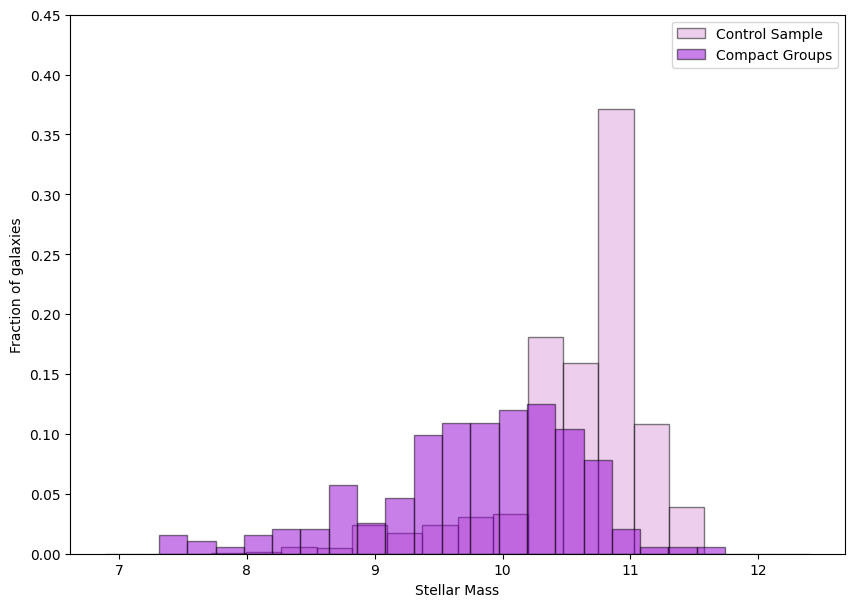

In [38]:
plt.figure(figsize=(10, 7))

cs_mass = control_sample[control_sample['log_M_stellar']>0]['log_M_stellar']
groups_mass = sfr_decals_z['log(M_stellar)']

# Calcular los histogramas sin normalización
counts1, bins1, _ = plt.hist(cs_mass, bins=20, density=False, alpha=0.5, label='Control Sample')
counts2, bins2, _ = plt.hist(groups_mass, bins=20, density=False, alpha=0.5, label='Compact Groups')

# Limpiar la figura
plt.clf()

# Normalizar y volver a plotear
plt.hist(bins1[:-1], bins=bins[1], weights=counts1 / len(cs_mass), alpha=0.5, label='Control Sample', color='plum', edgecolor='black')
plt.hist(bins2[:-1], bins=20, weights=counts2 / len(groups_mass), alpha=0.5, label='Compact Groups', color='darkviolet', edgecolor='black')

# Establecer los límites del eje y
plt.ylim(0, 0.45)

# Etiquetas y leyenda
plt.xlabel('Stellar Mass')
plt.ylabel('Fraction of galaxies')
plt.legend()

# Mostrar el gráfico
plt.show()

In [167]:
H_0 = 67.4 #km/s/Mpc

decals_ssfr['Distance (Mpc)'] = (decals_ssfr['zmemb']*300000)/H_0
decals_ssfr['RE_g(kpc)'] = (decals_ssfr['RE_g']*decals_ssfr['Distance (Mpc)'])/206.265
decals_ssfr['RE_r(kpc)'] = (decals_ssfr['RE_r']*decals_ssfr['Distance (Mpc)'])/206.265
decals_ssfr['RE_z(kpc)'] = (decals_ssfr['RE_z']*decals_ssfr['Distance (Mpc)'])/206.265
decals_ssfr['e_RE_r(kpc)'] = (decals_ssfr['e_RE_r']*decals_ssfr['Distance (Mpc)'])/206.265


decals_ssfr = decals_ssfr[~np.isnan(decals_ssfr['RE_g(kpc)'])]
decals_ssfr = decals_ssfr[~np.isnan(decals_ssfr['RE_r(kpc)'])]
decals_ssfr = decals_ssfr[~np.isnan(decals_ssfr['RE_z(kpc)'])]

decals_ssfr = decals_ssfr[decals_ssfr['RE_g(kpc)']<100]
print(np.nanmedian(decals_ssfr['log_sSFR']))#[(decals_ssfr['log(M_stellar)'] < 11) & (decals_ssfr['log(M_stellar)'] > 10)]))
print(np.nanstd(decals_ssfr['log_sSFR']))#[(decals_ssfr['log(M_stellar)'] < 11) & (decals_ssfr['log(M_stellar)'] > 10)]))

-9.566687835286421
0.8337364905957331


/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


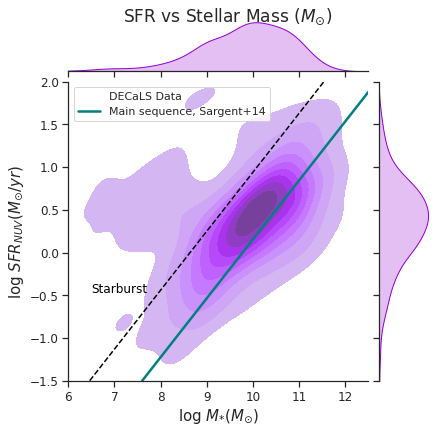

In [146]:
sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_ssfr['logSFR_NUV']
x=decals_ssfr['log(M_stellar)']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_ssfr,
    x=x, y=y,
    kind="kde",
    fill=True,
    color='darkviolet',
    alpha=1,
    label='DECaLS Data'
)
# Añadir un título al gráfico
g.fig.suptitle("SFR vs Stellar Mass $(M_{\odot})$", fontsize=17)
g.fig.subplots_adjust(top=0.95)  # Ajustar para que el título no se superponga con el gráfico

# Añadir una recta que pase por el punto (x, y) = (0.25, 0.25)
g.ax_joint.axline((9, 0.25), slope=0.69, color='black', linestyle='--')
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.5)
g.ax_joint.set_ylim(-1.5, 2)
g.ax_joint.text(6.5, -0.5, 'Starburst', color='black', fontsize=12, verticalalignment='bottom')
# Añadir una segunda recta continua con un label
g.ax_joint.axline((10.5, 0.5), slope=0.69, color='teal', linestyle='-', label='Main sequence, Sargent+14', linewidth=2.5)
g.set_axis_labels("log $M_{*} (M_{\odot})$", "log $SFR_{NUV} (M_{\odot}/yr)$", fontsize=15)
g.ax_joint.tick_params(axis='both', labelsize=12)  # Cambia 12 por el tamaño de fuente deseado
# Mostrar la leyenda con el label de la recta continua
g.ax_joint.legend()

plt.show()

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


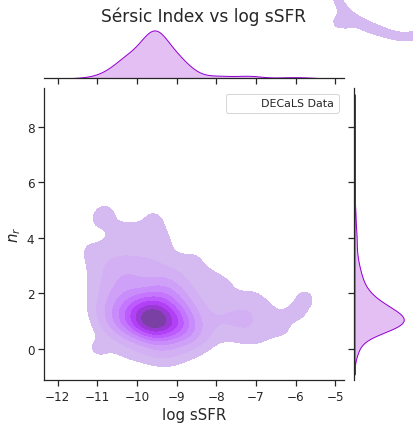

In [147]:
sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_ssfr['n_r']
x=decals_ssfr['log_sSFR']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_ssfr,
    x=x, y=y,
    kind="kde",
    fill=True,
    color='darkviolet',
    label='DECaLS Data'
)
g.set_axis_labels('log sSFR', '$n_{r}$', fontsize=15)
g.fig.suptitle("Sérsic Index vs log sSFR", fontsize=17)
g.fig.subplots_adjust(top=0.93)
g.ax_joint.tick_params(axis='both', labelsize=12)
g.ax_joint.legend()

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


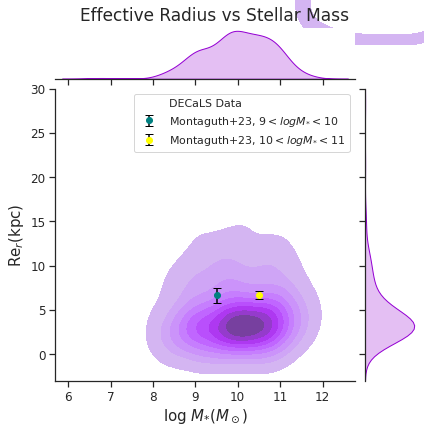

In [110]:
sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_ssfr['RE_r']
x=decals_ssfr['log(M_stellar)']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_ssfr,
    x=x, y=y,
    kind="kde",
    fill=True,
    color='darkviolet',
    label='DECaLS Data'
)
g.ax_joint.set_ylim(-3, 30)
g.set_axis_labels('log $M_{*} (M_\odot)$', 'Re$_{r}$(kpc)', fontsize=15)
g.fig.suptitle("Effective Radius vs Stellar Mass", fontsize=17)
g.fig.subplots_adjust(top=0.93)
g.ax_joint.tick_params(axis='both', labelsize=12)

# Añadir un punto con error
x_point = 9.5  # Coordenada x del punto
y_point = 6.67  # Coordenada y del punto
x_error = 0.5  # Error en x
y_error = 0.85  # Error en y

g.ax_joint.errorbar(x_point, y_point, yerr=y_error, fmt='o', color='teal', ecolor='black', capsize=4, label='Montaguth+23, $9 < log M_{*} < 10$')

# Añadir un punto con error
x_point_2 = 10.5  # Coordenada x del punto
y_point_2 = 6.6495  # Coordenada y del punto
x_error_2 = 0.5  # Error en x
y_error_2 = 0.45  # Error en y

g.ax_joint.errorbar(x_point_2, y_point_2, yerr=y_error_2, fmt='o', color='yellow', ecolor='black', capsize=4, label='Montaguth+23, $10 < log M_{*} < 11$')

g.ax_joint.legend()

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


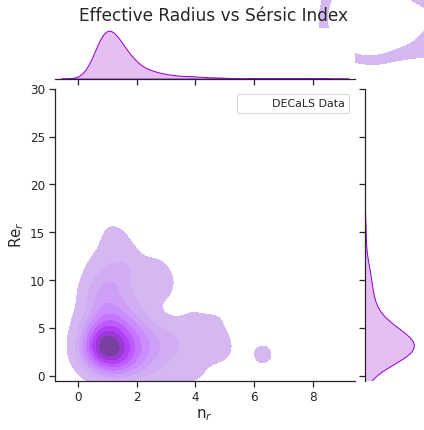

In [89]:
sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_ssfr['RE_r']
x=decals_ssfr['n_r']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_ssfr,
    x=x, y=y,
    kind="kde",
    fill=True,
    color='darkviolet',
    label='DECaLS Data'
)
g.ax_joint.set_ylim(-0.5, 30)
g.set_axis_labels('n$_{r}$', 'Re$_{r}$', fontsize=15)
g.fig.suptitle("Effective Radius vs Sérsic Index", fontsize=17)
g.fig.subplots_adjust(top=0.93)
g.ax_joint.tick_params(axis='both', labelsize=12)
g.ax_joint.legend()

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


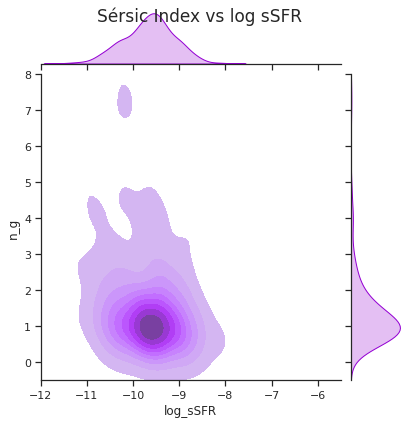

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


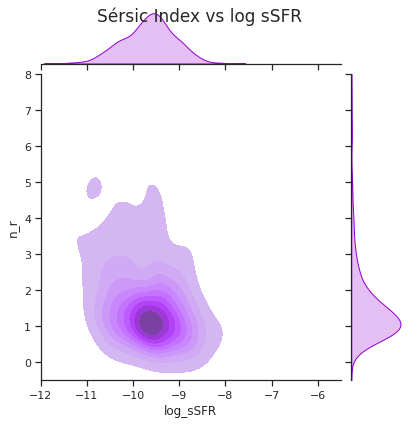

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


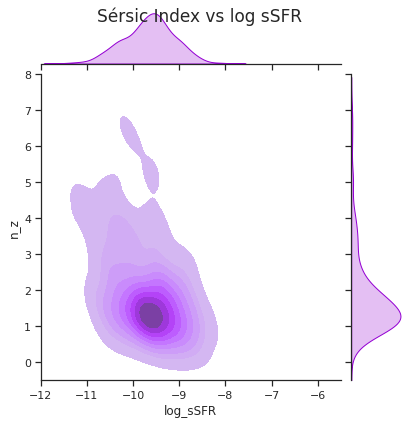

In [91]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")

# Definir los datos
x = decals_ssfr['log_sSFR']
#sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    g = sns.jointplot(
        data=decals_ssfr,
        x=x, y=decals_ssfr[col],
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=True,# Llenar las curvas para mejor visualización
        color='darkviolet',
        alpha=1
    ).set_axis_labels("log_sSFR", f"{col}")
    g.fig.suptitle("Sérsic Index vs log sSFR", fontsize=17)
    g.ax_joint.set_xlim(-12, -5.5)
    g.ax_joint.set_ylim(-0.5, 8)
    plt.show()  # Mostrar cada gráfico por separado


/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


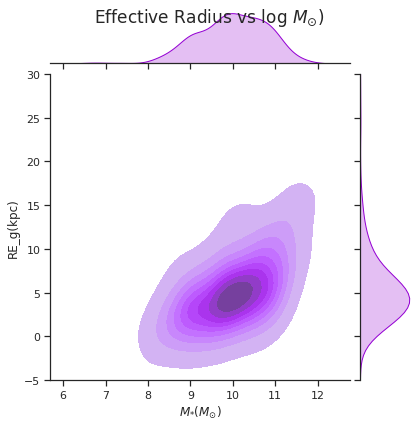

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


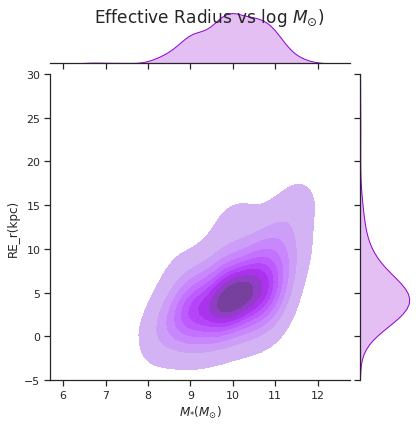

/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:330: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/seba/anaconda3/lib/python3.9/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


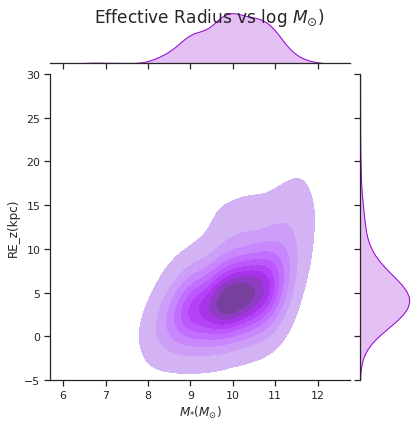

In [71]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")

# Definir los datos
x = decals_ssfr['log(M_stellar)']
#sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    g = sns.jointplot(
        data=sfr_decals,
        x=x, y=decals_ssfr[col],
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=True,# Llenar las curvas para mejor visualización
        color='darkviolet',
        alpha=1
    ).set_axis_labels("$M_{*} (M_{\odot})$", f"{col}")
    g.fig.suptitle("Effective Radius vs log $M_{\odot})$", fontsize=17)
    #g.ax_joint.set_xlim(-12, -5.5)
    g.ax_joint.set_ylim(-5, 30)
    plt.show()  # Mostrar cada gráfico por separado